<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./00_index.ipynb"><< Index </a><br>
<a href="./02_AC_SAF_GOME-2_L2_produce_gridded_dataset_L3.ipynb"><< 02 - AC SAF GOME-2 - Produce gridded dataset (L3)</a>

<br>

<div class="alert alert-block alert-success">
<b>COVID-19 case study</b></div>

# GOME-2 Tropospheric NO<sub>2</sub> Anomaly map (March 2020)

This workflow shows how to produce a anomaly map of GOME-2 Level 2 tropospheric NO<sub>2</sub> for a specific month in 2020 compared to the longterm average of tropospheric NO<sub>2</sub> based on GOME-2 Level 3 data between 2007 and 2017.

You will use GOME-2 Level 2 data from both satellites, Metop-A and Metop-B, as well as Level 3 data from February 2007 and 2017.
The first step is to produce a gridded Level 3 dataset of average tropospheric NO<sub>2</sub> from Level 2 data. The second step is create longterm monthly mean for each month from GOME-2 Level 3 data. The last step is the creation of the anomaly map.



### Data used
- [GOME-2 Metop-A/B OFFLINE data for March 2020](#gome_2_level_3)
- [GOME-2 NO2 Level 3 data from Feb 2007 to Nov 2017](#level3)

### Workflow outline

- [Create GOME-2 Level 3 gridded product of tropospheric NO2 data for March 2020](#gome_2_level_3)
  - [Load the Metop-A GOME-2 offline files for one month](#load_gome2a)
  - [Load the Metop-B GOME-2 offline files for one month](#load_gome2b)
  - [Concatenate data from Metop-A and Metop-B for March 2020](#concat)
  - [Binning (gridding) of L2 data onto a defined two-dimensional grid](#binning)
  - [Visualize monthly average gridded data for March 2020](#visualize_2020)
- [Load GOME-2 Level 3 data and create longterm monthly mean](#level3)
- [Generate anomaly map based on the longterm mean of tropospheric NO2](#anomaly_map)

<br>

#### Load required libraries

In [2]:
import os
import xarray as xr
import numpy as np
import netCDF4 as nc

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import cartopy.feature as cfeature

import glob
import pandas as pd

from datetime import datetime

import ipynb

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [3]:
from ipynb.fs.full.functions import load_l2_data_xr, visualize_pcolormesh, generate_masked_array, generate_geographical_subset


<hr>

## <a id='gome_2_level_3'></a>Create GOME-2 Level 3 gridded product of tropospheric NO2 data for March 2020

#### Define the folder paths

In [4]:
directory_2a= './eodata/gome2/offline/2a/2020/03/'
directory_2b= './eodata/gome2/offline/2b/2020/03/'

<br>

### <a id='load_gome2a'></a>Load the Metop-A GOME-2 offline files for one month as `xarray.DataArray` object

Within the repspective data folder, the data is organised per day. With the `glob` library, you can create folder lists based on a specific naming pattern. Thus, as a first step, let us create a list of folders, for both folder paths.

In [5]:
folder_list_2a = sorted(glob.glob(directory_2a+'*'))

folder_list_2b = sorted(glob.glob(directory_2b+'*'))
folder_list_2b

['./eodata/gome2/offline/2b/2020/03/01',
 './eodata/gome2/offline/2b/2020/03/02',
 './eodata/gome2/offline/2b/2020/03/03',
 './eodata/gome2/offline/2b/2020/03/04',
 './eodata/gome2/offline/2b/2020/03/05',
 './eodata/gome2/offline/2b/2020/03/06',
 './eodata/gome2/offline/2b/2020/03/07',
 './eodata/gome2/offline/2b/2020/03/08',
 './eodata/gome2/offline/2b/2020/03/09',
 './eodata/gome2/offline/2b/2020/03/10',
 './eodata/gome2/offline/2b/2020/03/11',
 './eodata/gome2/offline/2b/2020/03/12',
 './eodata/gome2/offline/2b/2020/03/13',
 './eodata/gome2/offline/2b/2020/03/14',
 './eodata/gome2/offline/2b/2020/03/15',
 './eodata/gome2/offline/2b/2020/03/16',
 './eodata/gome2/offline/2b/2020/03/17',
 './eodata/gome2/offline/2b/2020/03/18',
 './eodata/gome2/offline/2b/2020/03/19',
 './eodata/gome2/offline/2b/2020/03/20',
 './eodata/gome2/offline/2b/2020/03/21',
 './eodata/gome2/offline/2b/2020/03/22',
 './eodata/gome2/offline/2b/2020/03/23',
 './eodata/gome2/offline/2b/2020/03/24',
 './eodata/gome2

<br>

#### Load `NO2Tropo`, `CloudFraction` and `IndexInScan` variables with the function `load_l2_data_xr`

For the first day in the folder list, you can create a `xarray.DataArray` object. Use the function [load_l2_data_xr](./functions.ipynb#load_l2) to load the information for `NO2Tropo`, `CloudFraction` and `IndexInScan`. The function loads a Metop-A/B Level 2 dataset in HDF format and returns a `xarray.DataArray` with all the ground pixels of all directory files. 

Load the `NO2Tropo` information.

In [6]:
data_array_a = load_l2_data_xr(folder_list_2a[0], 
                               'TOTAL_COLUMNS', 
                               'NO2Tropo', 
                               'GEOLOCATION/LatitudeCentre', 
                               'GEOLOCATION/LongitudeCentre', 
                               1, 
                               paramname='NO2Tropo', 
                               unit='mol/cm\u00b2',
                               longname='Tropospheric column density of NO2')
data_array_a

<xarray.DataArray 'NO2Tropo' (ground_pixel: 211163)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 78.54998 78.497986 ... -84.389786
    longitude  (ground_pixel) float32 198.78352 196.99515 ... 41.96278 38.35278
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm²

<br>

Load the `CloudFraction` information:

In [7]:
cloud_fraction_a = load_l2_data_xr(folder_list_2a[0],
                                   'CLOUD_PROPERTIES', 
                                   'CloudFraction', 
                                   'GEOLOCATION/LatitudeCentre', 
                                   'GEOLOCATION/LongitudeCentre', 
                                   1, 
                                   paramname='cloud_fraction', 
                                   unit='-', 
                                   longname='Cloud Fraction')

cloud_fraction_a

<xarray.DataArray 'cloud_fraction' (ground_pixel: 211163)>
array([0.9896364 , 0.8773051 , 0.9714895 , ..., 0.7652889 , 0.7581082 ,
       0.75459504], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 78.54998 78.497986 ... -84.389786
    longitude  (ground_pixel) float32 198.78352 196.99515 ... 41.96278 38.35278
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Cloud Fraction
    units:      -

<br>

Load the `IndexInScan` information:

In [8]:
index_scan_a = load_l2_data_xr(folder_list_2a[0],
                               'GEOLOCATION', 
                               'IndexInScan', 
                               'GEOLOCATION/LatitudeCentre', 
                               'GEOLOCATION/LongitudeCentre', 
                               1, 
                               paramname='indexflag', 
                               unit='-', 
                               longname='Index in Scan')
index_scan_a

<xarray.DataArray 'indexflag' (ground_pixel: 211163)>
array([0, 0, 0, ..., 0, 0, 0], dtype=int32)
Coordinates:
    latitude   (ground_pixel) float32 78.54998 78.497986 ... -84.389786
    longitude  (ground_pixel) float32 198.78352 196.99515 ... 41.96278 38.35278
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Index in Scan
    units:      -

<br>

Next, loop through all the other days, load the variables as `xarray.DataArray` with the function [load_l2_data_xr](./functions.ipynb#load_l2). Once loaded, concatenate the new array with `xarray.concat()`. Do this for all three parameters: `NO2Tropo`, `CloudFraction` and `IndexInScan`.

In [9]:
for folder in folder_list_2a[1:]:
    print(folder)

    data_array = load_l2_data_xr(folder,
                                 'TOTAL_COLUMNS', 
                                 'NO2Tropo', 
                                 'GEOLOCATION/LatitudeCentre', 
                                 'GEOLOCATION/LongitudeCentre', 
                                 1, 
                                 paramname='NO2Tropo', 
                                 unit='mol/cm\u00b2',
                                 longname='Tropospheric column density of NO2')
    data_array_a = xr.concat([data_array_a, data_array], dim='ground_pixel')

    cloud_fraction = load_l2_data_xr(folder, 
                                     'CLOUD_PROPERTIES', 
                                     'CloudFraction', 
                                     'GEOLOCATION/LatitudeCentre', 
                                     'GEOLOCATION/LongitudeCentre', 
                                     1, 
                                     paramname='cloud_fraction', 
                                     unit='-', 
                                     longname='Cloud Fraction')
    cloud_fraction_a = xr.concat([cloud_fraction_a, cloud_fraction], dim='ground_pixel')

    index_scan = load_l2_data_xr(folder, 
                                 'GEOLOCATION', 
                                 'IndexInScan', 
                                 'GEOLOCATION/LatitudeCentre', 
                                 'GEOLOCATION/LongitudeCentre', 
                                 1, 
                                 paramname='indexflag', 
                                 unit='-', 
                                 longname='Index in Scan')
    index_scan_a = xr.concat([index_scan_a, index_scan], dim='ground_pixel')
    

./eodata/gome2/offline/2a/2020/03/02
./eodata/gome2/offline/2a/2020/03/03
./eodata/gome2/offline/2a/2020/03/04
./eodata/gome2/offline/2a/2020/03/05
./eodata/gome2/offline/2a/2020/03/06
./eodata/gome2/offline/2a/2020/03/07
./eodata/gome2/offline/2a/2020/03/08
./eodata/gome2/offline/2a/2020/03/09
./eodata/gome2/offline/2a/2020/03/10
./eodata/gome2/offline/2a/2020/03/11
./eodata/gome2/offline/2a/2020/03/12
./eodata/gome2/offline/2a/2020/03/13
./eodata/gome2/offline/2a/2020/03/14
./eodata/gome2/offline/2a/2020/03/15
./eodata/gome2/offline/2a/2020/03/16
./eodata/gome2/offline/2a/2020/03/17
./eodata/gome2/offline/2a/2020/03/18
./eodata/gome2/offline/2a/2020/03/19
./eodata/gome2/offline/2a/2020/03/20
./eodata/gome2/offline/2a/2020/03/21
./eodata/gome2/offline/2a/2020/03/22
./eodata/gome2/offline/2a/2020/03/23
./eodata/gome2/offline/2a/2020/03/24
./eodata/gome2/offline/2a/2020/03/25
./eodata/gome2/offline/2a/2020/03/26
./eodata/gome2/offline/2a/2020/03/27
./eodata/gome2/offline/2a/2020/03/28
.

<br>

Now, repeat the same steps for the Metop-B GOME-2 data files.

<br>

### <a id='load_gome2b'></a> Load the Metop-B GOME-2 offline files for one month as `xarray.DataArray` object

For the first day in the folder list, load the `NO2Tropo`, `CloudFraction` and `IndexInScan` information as `xarray.DataArray` object.

Load `NOTropo`:

In [10]:
data_array_b = load_l2_data_xr(folder_list_2b[0],
                               'TOTAL_COLUMNS', 
                               'NO2Tropo', 
                               'GEOLOCATION/LatitudeCentre', 
                               'GEOLOCATION/LongitudeCentre', 
                               1, 
                               paramname='NO2Tropo', 
                               unit='mol/cm\u00b2',
                               longname='Tropospheric column density of NO2')
data_array_b

<xarray.DataArray 'NO2Tropo' (ground_pixel: 209865)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 75.51396 75.468124 ... -86.194374
    longitude  (ground_pixel) float32 216.13277 214.70442 ... 19.135382
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm²

<br>

Load `CloudFraction` information:

In [11]:
cloud_fraction_b = load_l2_data_xr(folder_list_2b[0],
                                   'CLOUD_PROPERTIES', 
                                   'CloudFraction', 
                                   'GEOLOCATION/LatitudeCentre', 
                                   'GEOLOCATION/LongitudeCentre', 
                                   1, 
                                   paramname='cloud_fraction', 
                                   unit='-', 
                                   longname='Cloud Fraction')
cloud_fraction_b

<xarray.DataArray 'cloud_fraction' (ground_pixel: 209865)>
array([0.9883544 , 0.97632164, 0.9713981 , ..., 0.67418593, 0.7164886 ,
       0.75304663], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 75.51396 75.468124 ... -86.194374
    longitude  (ground_pixel) float32 216.13277 214.70442 ... 19.135382
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Cloud Fraction
    units:      -

<br>

Load `IndexInScan` information:

In [12]:
index_scan_b = load_l2_data_xr(folder_list_2b[0],
                               'GEOLOCATION', 
                               'IndexInScan', 
                               'GEOLOCATION/LatitudeCentre', 
                               'GEOLOCATION/LongitudeCentre', 
                               1, 
                               paramname='indexflag', 
                               unit='-', 
                              longname='Index in Scan')
index_scan_b

<xarray.DataArray 'indexflag' (ground_pixel: 209865)>
array([0, 0, 0, ..., 0, 0, 0], dtype=int32)
Coordinates:
    latitude   (ground_pixel) float32 75.51396 75.468124 ... -86.194374
    longitude  (ground_pixel) float32 216.13277 214.70442 ... 19.135382
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Index in Scan
    units:      -

<br>

Next, loop through all the other days, load the variables as `xarray.DataArray` with the function [load_l2_data_xr](./functions.ipynb#load_l2). Once loaded, concatenate the new array with `xarray.concat()`. Do this for all three parameters: `NO2Tropo`, `CloudFraction` and `IndexInScan`.

In [13]:
for folder in folder_list_2b[1:]:
    print(folder)
    data_array = load_l2_data_xr(folder,
                                 'TOTAL_COLUMNS', 
                                 'NO2Tropo', 
                                 'GEOLOCATION/LatitudeCentre', 
                                 'GEOLOCATION/LongitudeCentre', 
                                 1, 
                                 paramname='NO2Tropo', 
                                 unit='mol/cm\u00b2',
                                 longname='Tropospheric column density of NO2')
    data_array_b = xr.concat([data_array_b, data_array], dim='ground_pixel')
    
    cloud_fraction = load_l2_data_xr(folder,
                                     'CLOUD_PROPERTIES', 
                                     'CloudFraction', 
                                     'GEOLOCATION/LatitudeCentre', 
                                     'GEOLOCATION/LongitudeCentre', 
                                     1, 
                                     paramname='cloud_fraction', 
                                     unit='-', 
                                     longname='Cloud Fraction')
    cloud_fraction_b = xr.concat([cloud_fraction_b, cloud_fraction], dim='ground_pixel')

    index_scan = load_l2_data_xr(folder, 
                                 'GEOLOCATION', 
                                 'IndexInScan', 
                                 'GEOLOCATION/LatitudeCentre', 
                                 'GEOLOCATION/LongitudeCentre', 
                                 1, 
                                 paramname='indexflag', 
                                 unit='-', 
                                 longname='Index in Scan')
    index_scan_b = xr.concat([index_scan_b, index_scan], dim='ground_pixel')

./eodata/gome2/offline/2b/2020/03/02
./eodata/gome2/offline/2b/2020/03/03
./eodata/gome2/offline/2b/2020/03/04
./eodata/gome2/offline/2b/2020/03/05
./eodata/gome2/offline/2b/2020/03/06
./eodata/gome2/offline/2b/2020/03/07
./eodata/gome2/offline/2b/2020/03/08
./eodata/gome2/offline/2b/2020/03/09
./eodata/gome2/offline/2b/2020/03/10
./eodata/gome2/offline/2b/2020/03/11
./eodata/gome2/offline/2b/2020/03/12
./eodata/gome2/offline/2b/2020/03/13
./eodata/gome2/offline/2b/2020/03/14
./eodata/gome2/offline/2b/2020/03/15
./eodata/gome2/offline/2b/2020/03/16
./eodata/gome2/offline/2b/2020/03/17
./eodata/gome2/offline/2b/2020/03/18
./eodata/gome2/offline/2b/2020/03/19
./eodata/gome2/offline/2b/2020/03/20
./eodata/gome2/offline/2b/2020/03/21
./eodata/gome2/offline/2b/2020/03/22
./eodata/gome2/offline/2b/2020/03/23
./eodata/gome2/offline/2b/2020/03/24
./eodata/gome2/offline/2b/2020/03/25
./eodata/gome2/offline/2b/2020/03/26
./eodata/gome2/offline/2b/2020/03/27
./eodata/gome2/offline/2b/2020/03/28
.

<br>

Now, let us concatenate the data object with data from Metop-A and Metop-B

<br>

### <a id='concat'></a>Concatenate data from Metop-A and Metop-B for March 2020

You can use `xarray.concat()` to concatenate the data arrays of Metop-A and Metop-B. The dimension you want to concatenate both arrays is `ground_pixel`.

Do this for the data arrays of the three parameters: `NO2Tropo`, `CloudFraction` and `IndexInScan`.

In [14]:
data_ab = xr.concat([data_array_a, data_array_b], dim='ground_pixel')

cloud_fraction_ab = xr.concat([cloud_fraction_a, cloud_fraction_b], dim='ground_pixel')

index_scan_ab = xr.concat([index_scan_a, index_scan_b], dim='ground_pixel')

<br>

The result is a data array with over 12 Mio. ground pixel information.

In [15]:
data_ab

<xarray.DataArray 'NO2Tropo' (ground_pixel: 12619560)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 78.54998 78.497986 ... -77.769325
    longitude  (ground_pixel) float32 198.78352 196.99515 ... 119.39467
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm²

<br>

Let us store the `longname` and `units` attributes that can be used for plotting later.

In [16]:
longname = data_ab.long_name
units = data_ab.units

<br>

### Flag negative values and pixels with a cloud faction higher than 20%

The next step is to mask invalid pixels. Invalid pixels are flagged out in three ways:
- Remove pixels with negative values
- Pixels with a cloud fraction higher than 20%, and
- backward scan pixels

Low quality measurements are flagged out in three ways:
- negative values
- pixels with a cloud fraction higher than 20%, and
- backward scan pixels

<br>

#### Flag negative values from the NO2 data array

Negative values can be flagged out with xarray's function `xr.where`. We cast only positive values and if value is negative, it is replaced with `NaN`.

In [17]:
data_ab_flagged = xr.where(data_ab > 0, data_ab, np.nan)
data_ab_flagged

<xarray.DataArray 'NO2Tropo' (ground_pixel: 12619560)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 78.54998 78.497986 ... -77.769325
    longitude  (ground_pixel) float32 198.78352 196.99515 ... 119.39467
Dimensions without coordinates: ground_pixel

<br>

#### Mask backward scan pixels

The `IndexInScan` information is an integer value from 0 to 3, with the following descrition:
- 0-2 forward scan (0-east part of scan, 1-centre part of scan, 2-west part of scan)
- 3 backward scan
Thus, we want to mask out all pixels which have a index scan flag of three and want to keep the pixels with index scan flag 0, 1 and 2.

You can find more information on all the metadata of the GOME-2 Level 2 Trace Gas data in the [Product User Manual](https://acsaf.org/docs/pum/Product_User_Manual_NTO_OTO_DR_GDP48_Jun_2017.pdf).

For masking, we can use the function [generate_masked_array](./functions.ipynb#generate_masked_array). We set the drop keyword argument to `False` to ensure the same amount of ground pixels during the masking process.

In [18]:
no2_ab_masked_is = generate_masked_array(data_ab_flagged, index_scan_ab, 3 , '!=', drop=False)
no2_ab_masked_is

<xarray.DataArray (ground_pixel: 12619560)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 78.54998 78.497986 ... -77.769325
    longitude  (ground_pixel) float32 198.78352 196.99515 ... 119.39467
Dimensions without coordinates: ground_pixel

<br>

#### Mask cloud fraction information

We only want to keep pixels with a cloud fraction less than 20%. To mask it, we can use again the [generate_masked_array](./functions.ipynb#generate_masked_array) function and set the masking conditions to `less than` 0.2. We now set the drop keywork argument to `True`, as this is our last masking step and there is no benefit in keeping the non-valid pixels.

In [19]:
no2_ab_masked_is_cf = generate_masked_array(no2_ab_masked_is, cloud_fraction_ab, 0.2 , '<', drop=True)
no2_ab_masked_is_cf

<xarray.DataArray (ground_pixel: 945400)>
array([3.4500600e+15, 7.9134595e+15, 2.2353812e+15, ..., 9.4519755e+14,
       3.1140291e+14, 1.8073882e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 40.415627 40.505295 ... -63.425625
    longitude  (ground_pixel) float32 123.88063 123.42716 ... 116.09011
Dimensions without coordinates: ground_pixel

<br>

### <a id='binning'></a>Binning (gridding) of L2 data onto a defined two-dimensional grid

The longitude values of the AC SAF GOME-2 Level 2 data are stored as 0 to 360 degrees longitudes. In order to visualize the data on a -180 to 180 degrees grid, we have to convert the longitude values first. We can use the `assign_coords` function of the xarray library to re-assign the longitude values.

In [20]:
no2_ab_masked = no2_ab_masked_is_cf.assign_coords(longitude=(((no2_ab_masked_is_cf.longitude + 180) % 360) - 180))
no2_ab_masked

<xarray.DataArray (ground_pixel: 945400)>
array([3.4500600e+15, 7.9134595e+15, 2.2353812e+15, ..., 9.4519755e+14,
       3.1140291e+14, 1.8073882e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 40.415627 40.505295 ... -63.425625
    longitude  (ground_pixel) float32 123.880615 123.427155 ... 116.09012
Dimensions without coordinates: ground_pixel

<br>

#### Retrieve data values and latitude and longitude data information


For the binning process, we need the latitude and longitudde information. We can retrieve the data from our masked data object.

In [21]:
y = no2_ab_masked.latitude.data
x = no2_ab_masked.longitude.data

x, y

(array([123.880615, 123.427155, 124.643005, ..., 115.178314, 117.898865,
        116.09012 ], dtype=float32),
 array([ 40.415627,  40.505295,  39.885746, ..., -62.513126, -63.32647 ,
        -63.425625], dtype=float32))

<br>

And we also want to retrieve the NO2 data values and call the new variable `z`.

In [22]:
z = no2_ab_masked.data

<br>

With `np.histogram2d`, we can bin the data onto a pre-defined 2-dimensional grid (called bins). By assigning our data value object `z` to the keyword argument `weights`, the bin gets assigned the data value of the point that falls into the cell.

Since there will be more data points assigned to one cell (bin), we also create a `counts` array, which sums up the number of data points fallen into a bin.

The example below builds a regular grid of 0.25 deg x 0.25 deg.

<br>

#### Bin the data onto a 2D-grid with `np.histogram2d`

In [23]:
zi, yi, xi = np.histogram2d(y, x, bins=(720,1440), weights=z, normed=False)
counts, _, _ = np.histogram2d(y, x, bins=(720,1440))


<br>

#### Build the `arithmetic mean` of all the data points fallen into a bin

The `counts` array can be used to build the`arithmetic mean` of all the data points fallen into one bin.

In [24]:
zi_2003 = zi / counts


<br>

#### Define a `xarray.DataArray` to store the binned array

In [25]:
data_array_2003 = xr.DataArray(
                zi_2003,
                dims=['latitude','longitude'],
                coords={
                    'time': pd.to_datetime('2020-03'),
                    'latitude':(['latitude'], yi[:-1]),
                    'longitude':(['longitude'],xi[:-1])
                },
                attrs={'long_name': longname, 'units': units},
                name='NO2_tropo'
            )

<br>

### <a id='visualize_2020'></a>Visualize monthly average gridded data for March 2020

#### Define a list with dictionaries holding bounding boxes for different regions

You can define several regions as a dictionary, e.g. the bounding box information for Europe or the Hubei region in China. The dictionaries are stored in a list.

In [26]:
# Europe extent
eur_extent={'name': 'eur_extent',
    'lonmin':-10.0,
            'lonmax':30.0,
            'latmin':35.0,
            'latmax':60.0}

# China (Hubei, Wuhan)
hubei_extent={'name': 'hubei_extent',
    'lonmin':112.0,
            'lonmax':118.0,
            'latmin':28.0,
            'latmax':33.0}

region_list=[eur_extent,
            hubei_extent]

<br>

The final step is to visualize the gridded data array, together with the latitude and longitude information. We can use the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh) to plot the data with matplotlib's plotting function `pcolormesh`.

We define a `conversion_factor=1e-15` and multiply the NO2 values with it to facilitate the plotting.

In [27]:
conversion_factor=1e-15

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Tropospheric column density of NO2 - Gridded level 3 data for 1-31 March 2020'}>)

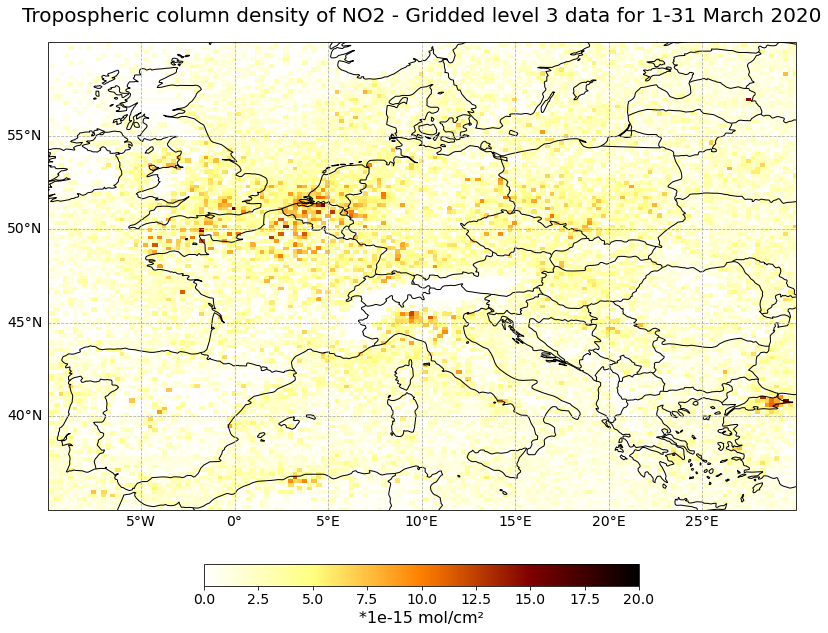

In [28]:
visualize_pcolormesh(data_array_2003*conversion_factor, 
                     data_array_2003.longitude, 
                     data_array_2003.latitude, 
                     ccrs.PlateCarree(), 
                     'afmhot_r', 
                     '*1e-15 ' + units, 
                     longname + ' - Gridded level 3 data for 1-31 March 2020', 
                      0, 20, 
                      region_list[0]['lonmin'],
                      region_list[0]['lonmax'], 
                      region_list[0]['latmin'], 
                      region_list[0]['latmax'], 
                      log=False, 
                      set_global=False)

<br>

### Optional: Safe the data array of gridded tropospheric NO<sub>2</sub> values for March 2020

Let us safe the gridded data as `netCDF` data file, as we might need to use the information for further analyses. By using the function `xarray.DataArray.to_netcdf()`, you can simply safe a xarray DataArray as `netCDF` data file.

In [ ]:
data_array_2003.to_netcdf('./2003_gome2_l3.nc', 'w') 


<br>

## <a id='level3'></a>Load GOME-2 Level 3 data and create longterm monthly mean

GOME-2 Level 3 data are available from February 2007 to November 2017. From this longterm time-series, you can create a longterm monthly mean that can be used as a basis to calculate anomalies.

#### Load the GOME-2 Level 3 data files as `xarray.DataArray` with the function `xarray.open_mfdataset()`

The GOME-2 Level 3 data are disseminated in `netCDF`. The function `xarray.open_mfdataset()` can be used to load the data for all month at once. Use `time` for the keyword argument `concat_dim`.

In [29]:
gome_l3 = xr.open_mfdataset('./eodata/gome2/level3/no2/*.nc', concat_dim='time', combine='nested',  group='PRODUCT')
gome_l3

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, time: 130)
Dimensions without coordinates: latitude, longitude, time
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

<br>

Above, you can see that the `xarray.Dataset` has three dimensions (`latitude`, `longitude` and `time`), but the dimensions do not have coordinates. But the coordinate information is required for plotting.

As a next step, we load one single GOME-2 Level 3 file and retrieve the `latitude` and `longitude` coordinates. You can use this information to assign the coordinates to the Dataset above.

In [31]:
ds = xr.open_dataset('./eodata/gome2/level3/no2/GOME_NO2_Global_201701_METOPB_DLR_v1.nc')
ds, ds.latitude, ds.longitude

(<xarray.Dataset>
 Dimensions:    (latitude: 720, longitude: 1440)
 Coordinates:
   * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
   * longitude  (longitude) float32 -179.875 -179.625 ... 179.625 179.875
 Data variables:
     *empty*
 Attributes:
     description:  Level 3 NO2 data
     Conventions:  CF-1.6,
 <xarray.DataArray 'latitude' (latitude: 720)>
 array([-89.875, -89.625, -89.375, ...,  89.375,  89.625,  89.875],
       dtype=float32)
 Coordinates:
   * latitude  (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
 Attributes:
     standard_name:  latitude
     long_name:      latitude_Centre, center of the grid box
     units:          degrees_north,
 <xarray.DataArray 'longitude' (longitude: 1440)>
 array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
       dtype=float32)
 Coordinates:
   * longitude  (longitude) float32 -179.875 -179.625 ... 179.625 179.875
 Attributes:
     standard_name:  longitude
     long_name:  

<br>

#### Assign coordinates to the dimensions `latitude`, `longitude` and `time`

You can use `pandas.data_range` to build a list of monthly time coordinates from February 2007 to November 2017.

In [32]:
# Build list of time coordinates with pandas
time_coords = pd.date_range('2007-02', '2017-11', freq='MS').strftime("%Y-%m").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2007-02-01', '2007-03-01', '2007-04-01', '2007-05-01',
               '2007-06-01', '2007-07-01', '2007-08-01', '2007-09-01',
               '2007-10-01', '2007-11-01',
               ...
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01'],
              dtype='datetime64[ns]', length=130, freq=None)

<br>

Use the function `xarray.assign_coords()` to assign `latitude`, `longitude` and `time` coordinates to the gome_l3 dataset.

In [33]:
# Assign values to Dataset dimension
gome_l3_assigned = gome_l3.assign_coords(latitude=ds.latitude, longitude=ds.longitude, time=time_coords)
gome_l3_assigned

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, time: 130)
Coordinates:
  * latitude         (latitude) float32 -89.875 -89.625 ... 89.625 89.875
  * longitude        (longitude) float32 -179.875 -179.625 ... 179.625 179.875
  * time             (time) datetime64[ns] 2007-02-01 2007-03-01 ... 2017-11-01
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

<br>

#### Create the longterm spatial average for each month

Use the `xarray.groupby().mean()` function to calculate the longterm mean of Tropospheric NO2 for each month. The resulting data array has 12 time entries, one for each month.

In [34]:
l3_spatial_mean = gome_l3_assigned.groupby('time.month').mean()
l3_spatial_mean

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, month: 12)
Coordinates:
  * latitude         (latitude) float32 -89.875 -89.625 ... 89.625 89.875
  * longitude        (longitude) float32 -179.875 -179.625 ... 179.625 179.875
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    NO2total         (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (month, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

<br>

#### Retrieve the data variable `NO2Trop` from the dataset

Select the data variable `NO2Trop` as the variable of interest.

In [35]:
no2_l3_spatial_mean = l3_spatial_mean.NO2trop
no2_l3_spatial_mean

<xarray.DataArray 'NO2trop' (month: 12, latitude: 720, longitude: 1440)>
dask.array<concatenate, shape=(12, 720, 1440), dtype=float32, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 -179.875 -179.625 ... 179.625 179.875
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<br>

#### Optional: Save the GOME-2 Level 3 climatology as `netCDF` 

In [ ]:
no2_l3_spatial_mean.to_netcdf('./no2_l3_climatology.nc', 'w')

<br>

#### Visualize the longterm average of tropospheric NO2 for a specific month

You can use the data array above and select a specific month and visualize it for Europe. You can use the function `xarray.isel(month=x)` to select a specific month. You can select `x=2` to visualize the longterm average for March.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Gridded level 3 data of Tropospheric column density of NO2 March Average'}>)

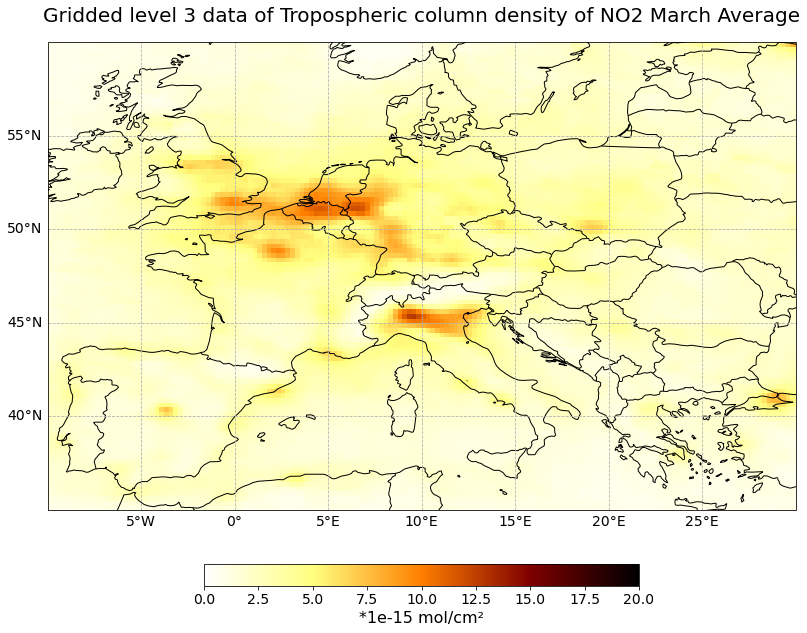

In [36]:
visualize_pcolormesh(no2_l3_spatial_mean.isel(month=2)*conversion_factor, 
                     no2_l3_spatial_mean.longitude, 
                     no2_l3_spatial_mean.latitude, 
                     ccrs.PlateCarree(), 
                    'afmhot_r', 
                    '*1e-15 ' + units, 
                    'Gridded level 3 data of ' + longname + ' March Average', 
                    0, 20, 
                    region_list[0]['lonmin'],
                    region_list[0]['lonmax'], 
                    region_list[0]['latmin'], 
                    region_list[0]['latmax'], 
                    log=False, 
                    set_global=False)

<br>

## <a id='anomaly_map'></a> Generate anomaly map based on the longterm mean of tropospheric NO2

#### Interpolate the gridded monthly map of 2020 onto the same grid of the longterm average

Before you can calculate the anomaly, you have to bring the two data array onto the same grid. You can use the xarray function `xarray.interp_like()` to bring it onto the regular grid of the GOME-2 Level 3 data, with a latitude longitude dimension of [720, 1440].

In [42]:
l3_2020_interpolated = data_array_2003.interp_like(no2_l3_spatial_mean)
l3_2020_interpolated

<xarray.DataArray 'NO2_tropo' (latitude: 720, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time       datetime64[ns] 2020-03-01
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    long_name:  Tropospheric column density of NO2
    units:      mol/cm²

<br>

#### Compute the anomaly map

You can calculate the anomaly of this year compared to the longterm average of tropospheric NO2 by subtracting the longterm average from the average values of this year.

Let us do the example of the anomaly for March 2020.

In [44]:
gome2_no2_202003_anomaly = l3_2020_interpolated - no2_l3_spatial_mean.sel(month=2)
gome2_no2_202003_anomaly

<xarray.DataArray (latitude: 720, longitude: 1440)>
dask.array<subtract, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 2020-03-01
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    month      int64 2

<br>

#### Visualize the anomaly map 

The last step is to visualize the anomaly map. You can use the function `visualize_pcolormesh` again. 

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'March anomaly of Tropospheric column density of NO2 - based on longterm mean (2007-2018)'}>)

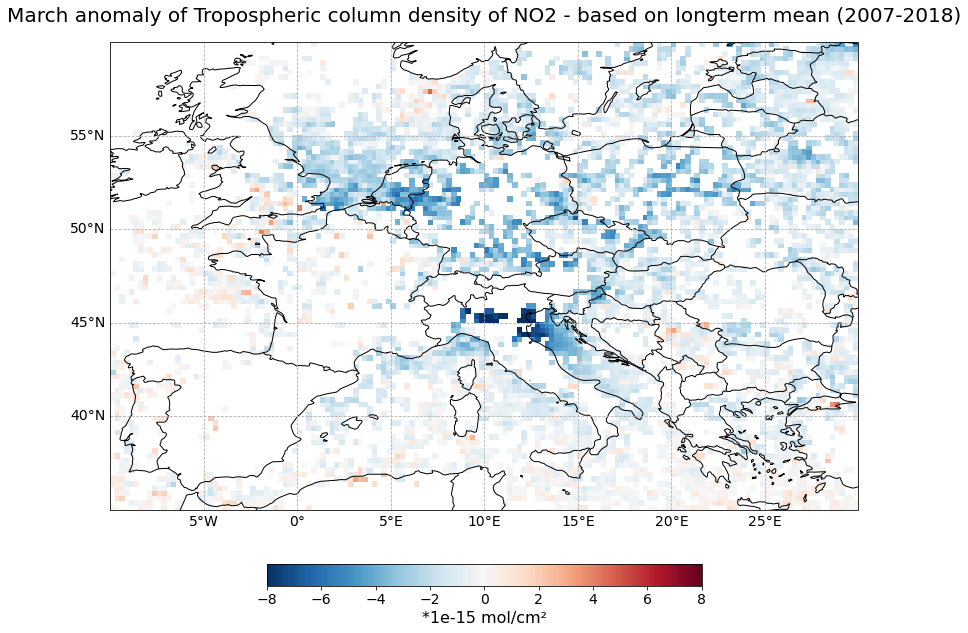

In [45]:
visualize_pcolormesh(gome2_no2_202003_anomaly*conversion_factor, 
                         gome2_no2_202003_anomaly.longitude, 
                         gome2_no2_202003_anomaly.latitude, 
                         ccrs.PlateCarree(), 
                         'RdBu_r', 
                         '*1e-15 ' + units, 
                         'March anomaly of ' + longname + ' - based on longterm mean (2007-2018)', 
                         -8, 8, 
                         region_list[0]['lonmin'],
                         region_list[0]['lonmax'], 
                         region_list[0]['latmin'], 
                         region_list[0]['latmax'], 
                         log=False, 
                         set_global=False)

<br>

<a href="./00_index.ipynb"><< Index </a><br>
<a href="./02_AC_SAF_GOME-2_L2_produce_gridded_dataset_L3.ipynb"><< 02 - AC SAF GOME-2 - Produce gridded dataset (L3)</a>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.